In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng
from lmfit.models import SineModel
from scipy.optimize import curve_fit
from typing import Optional
import sympy as sp
from sympy.plotting import plot3d
from components import point2d as p2
from components import point3d as p3
from components import antennaPair as antp
from components import antenna as ant
import itertools
import re
%matplotlib inline

In [91]:
DATA_FILE_PATH_LIST = [
    '..//data//triangulation_m100_0.csv',
    '..//data//triangulation_m50_m50.csv',
    '..//data//triangulation_m50_0.csv',
    '..//data//triangulation_m50_p50.csv'
    ]

In [92]:
DELTA_PHASE_0 = '..//data//triangulation_GTag_0.csv'

In [93]:
c = 2.998e8 #光の速度
f = 920.4e6 #周波数
WAVE_LENGTH = c / f * 100 #理論波長
THETA_M = 34 * np.pi / 180
MAX_L = WAVE_LENGTH / (2 * np.sin(THETA_M))
L = 25
R = 45
DATA_LENGTH = 100
print(f'波長λ:{WAVE_LENGTH}, Lの最大値:{MAX_L}')

波長λ:32.57279443720122, Lの最大値:29.124828154140907


In [94]:
REF_FILE_PATH_LIST = {
    'Pair1':'..//data//pair1_delta_phase_0.csv',
    'Pair2':'..//data//pair2_delta_phase_0.csv'
}

REF_TAG = 'E200 470F C1A0 6023 A8E6 010F'

In [95]:
TARGET_TAG = 'E200 470F C190 6023 A8E5 010E'

In [96]:
ANTENNA_PAIR_LIST = {
    'Pair1' : [ant.Antenna(point=p2.Point2d(-12.5, -178), frequency=920.4, number=2, theta_m=34),ant.Antenna(point=p2.Point2d(12.5, -178), frequency=920.4, number=1, theta_m=34)],
    'Pair2' : [ant.Antenna(point=p2.Point2d(12.5, 178), frequency=920.4, number=4, theta_m=34),ant.Antenna(point=p2.Point2d(-12.5, 178), frequency=920.4, number=3, theta_m=34)]
}

In [97]:
r0=np.sqrt(pow(R, 2) + pow((L/2), 2) + R * L)
actual_phase_0 = (-4 * np.pi / WAVE_LENGTH * r0) % (2 * np.pi)

In [98]:
def get_delta_rssi0(file_path:str, target_tag:str, ant_pair:list):
    df = pd.read_csv(file_path)
    df = df[df['Tag ID'] == target_tag]
    ant1_rssi = df[df['Antenna No.'] == ant_pair[0]]["RSSI"].mean()
    ant2_rssi = df[df['Antenna No.'] == ant_pair[1]]["RSSI"].mean()
    delta_rssi0 = ant1_rssi - ant2_rssi
    return delta_rssi0

def get_delta_phi0(file_path:str, target_tag:str, ant_pair:list):
    df = pd.read_csv(file_path)
    df = df[df['Tag ID'] == target_tag]
    ant1_frequency = df[df['Antenna No.'] == ant_pair[0]]["Phase"].mean()
    ant2_frequency = df[df['Antenna No.'] == ant_pair[1]]["Phase"].mean()
    return [ant1_frequency, ant2_frequency]
print(get_delta_phi0('..//data//triangulation_GTag_0.csv', REF_TAG, [4,6]))

[0.37183694298347947, 3.539814066124906]


In [99]:
# def get_delta_phi0(file, pair):
#     phi0_df = pd.read_csv(file)
#     phi0_df = phi0_df[phi0_df['Tag ID'] == 'E200 470F C1A0 6023 A8E6 010F']
#     phi0_df['Phase'] = phi0_df['Phase'].astype(float)
#     phi0_df['RSSI'] = phi0_df['RSSI'].astype(float)
#     phi0_df = phi0_df.drop(['Tag ID'], axis=1)
#     ant1_phi0 = phi0_df[phi0_df["Antenna No."]==pair[0].number]['Phase'].mean() + actual_phase_0
#     ant2_phi0 = phi0_df[phi0_df["Antenna No."]==pair[1].number]['Phase'].mean() + actual_phase_0
#     return [ant1_phi0, ant2_phi0]

In [100]:
class RfidDf:
    def __init__(self, csv_file:str, antenna_pair_list:dict, target_tag:str):
        self.df=pd.read_csv(csv_file)
        self.data_size = len(self.df)
        self.antenna_pair_list = antenna_pair_list
        self.target_tag = target_tag
        self.df = self.df[self.df['Tag ID'] == self.target_tag]
        self.df['Antenna Pair No.'] = self.df['Antenna No.'].apply(self.__get_antenna_pair_number)
        self.df['Phase'] = self.df['Phase'].astype(float)
        self.df['RSSI'] = self.df['RSSI'].astype(float)
        self.df = self.df.drop(['Tag ID'], axis=1).set_index(['Antenna Pair No.', 'Antenna No.', 'Data Number'])
    
    def __get_antenna_pair_number(self, antenna_number:int) -> str:
        for k in self.antenna_pair_list:
            for i in self.antenna_pair_list[k]:
                if i.number == antenna_number:
                    return k

    def __get_phase_diff(self, phase1:float, phase2:float, rssi1:float, rssi2:float, delta_phi0:list) -> float:
        delta_phi = (phase1-phase2)-delta_phi0[0]+delta_phi0[1]
        if (delta_phi < 0) & (rssi1 > rssi2):
            delta_phi = delta_phi + 2 * np.pi
        if (delta_phi >= 0) & (rssi1 <= rssi2):
            delta_phi = delta_phi - 2 * np.pi
        return delta_phi

    def __cul_angle_from_phase(self, phase1:float, phase2:float, rssi1:float, rssi2:float, delta_phi0:float) -> float:
        return np.arcsin(-WAVE_LENGTH / (4 * np.pi * L) * self.__get_phase_diff(phase1, phase2, rssi1, rssi2, delta_phi0))

    def get_data_array(self, pair:str) -> dict:
        data_array = {
            "phase_diff" : [],
            "angle" : []
        }
        ant1 = self.antenna_pair_list[pair][0]
        ant2 = self.antenna_pair_list[pair][1]
        phi0 = get_delta_phi0('..//data//triangulation_GTag_0.csv', REF_TAG, [4,6])
        for i in range(0, DATA_LENGTH):
            ant1_phase = (self.df.xs((pair, ant1.number, i))['Phase']) % (2 * np.pi)
            ant2_phase = (self.df.xs((pair, ant2.number, i))['Phase']) % (2 * np.pi)
            ant1_rssi = self.df.xs((pair, ant1.number, i))['RSSI']
            ant2_rssi = self.df.xs((pair, ant2.number, i))['RSSI']
            phase_diff = self.__get_phase_diff(ant1_phase, ant2_phase, ant1_rssi, ant2_rssi, phi0)
            angle = self.__cul_angle_from_phase(ant1_phase, ant2_phase, ant1_rssi, ant2_rssi, phi0)
            data_array["phase_diff"].append(phase_diff)
            data_array["angle"].append(angle)
        return data_array

    def get_coordinate(self) -> dict:
        data_array = np.empty((0, 2))
        pair1 = self.antenna_pair_list["Pair1"]
        pair2 = self.antenna_pair_list["Pair2"]
        pair1_angle_array = self.get_data_array(pair="Pair1")["angle"]
        pair2_angle_array = self.get_data_array(pair="Pair2")["angle"]
        pair1_point = p2.Point2d(x=(pair1[0].point.x + pair1[1].point.x) / 2, y=(pair1[0].point.y + pair1[1].point.y) / 2)
        pair2_point = p2.Point2d(x=(pair2[0].point.x + pair2[1].point.x) / 2, y=(pair2[0].point.y + pair2[1].point.y) / 2)
        for i in range(0, DATA_LENGTH):
            pair1_angle = pair1_angle_array[i]
            pair2_angle = pair2_angle_array[i]
            x = np.tan(pair1_angle) * np.tan(pair2_angle) / (np.tan(pair1_angle) - np.tan(pair2_angle)) * (pair1_point.y - pair2_point.y)
            y = (pair1_point.y * np.tan(pair1_angle) - pair2_point.y * np.tan(pair2_angle)) / (np.tan(pair1_angle) - np.tan(pair2_angle))
            data_array = np.append(
                data_array,
                [[
                    x,y
                ]],
                axis=0
            )
        df = pd.DataFrame(
            data=data_array,
            columns=["X", "Y"]
        )
        return df

In [101]:
def cul_rmse(actual_coordinate:dict, measured_coordinate:dict):
    rmse = np.sqrt(np.mean([pow(actual_coordinate["x"]-measured_coordinate["x"][i], 2)+pow(actual_coordinate["y"]-measured_coordinate["y"][i], 2) for i in range(0, DATA_LENGTH)]))
    return rmse

[147.1241720822025]


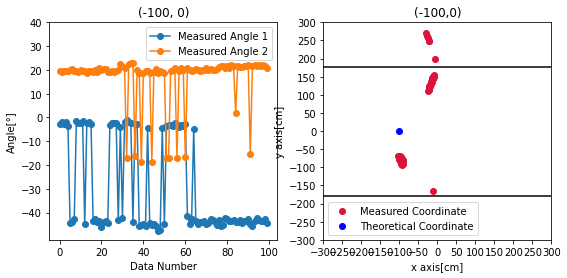

In [106]:
result = {}
triangulation = RfidDf(
    csv_file=DATA_FILE_PATH_LIST[0],
    antenna_pair_list=ANTENNA_PAIR_LIST,
    target_tag=TARGET_TAG,
)
result["angle_result1"]=triangulation.get_data_array("Pair1")["angle"]
result["angle_result2"]=triangulation.get_data_array("Pair2")["angle"]
result["coordinate"]=triangulation.get_coordinate()
rmse = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result1"]], marker='o', label="Measured Angle 1")
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result2"]], marker='o', label="Measured Angle 2")
ax1.set_ylabel("Angle[°]")
ax1.set_xlabel("Data Number")
ax1.set_yticks(range(-40, 45, 10))
ax1.set_title("(-100, 0)")
ax1.legend()
ax2.scatter(result["coordinate"]["X"], result["coordinate"]["Y"], label="Measured Coordinate", color="crimson")
ax2.scatter([-100], [0], label="Theoretical Coordinate", color="blue")
ax2.plot(range(-500, 550, 50), [178 for i in range(-500, 550, 50)], color="black")
ax2.plot(range(-500, 550, 50), [-178 for i in range(-500, 550, 50)], color="black")
ax2.set_xlim(-300, 300)
ax2.set_ylim(-300, 300)
ax2.set_xticks(range(-300, 350, 50))
ax2.set_yticks(range(-300, 350, 50))
ax2.set_ylabel('y axis[cm]')
ax2.set_xlabel('x axis[cm]')
ax2.set_title("(-100,0)")
rmse.append(cul_rmse(
    {
        "x":-100,
        "y":0
    },
    {
        "x":result["coordinate"]["X"],
        "y":result["coordinate"]["Y"]
    }
))
ax2.legend()
print(rmse)

[68.95749307226723]


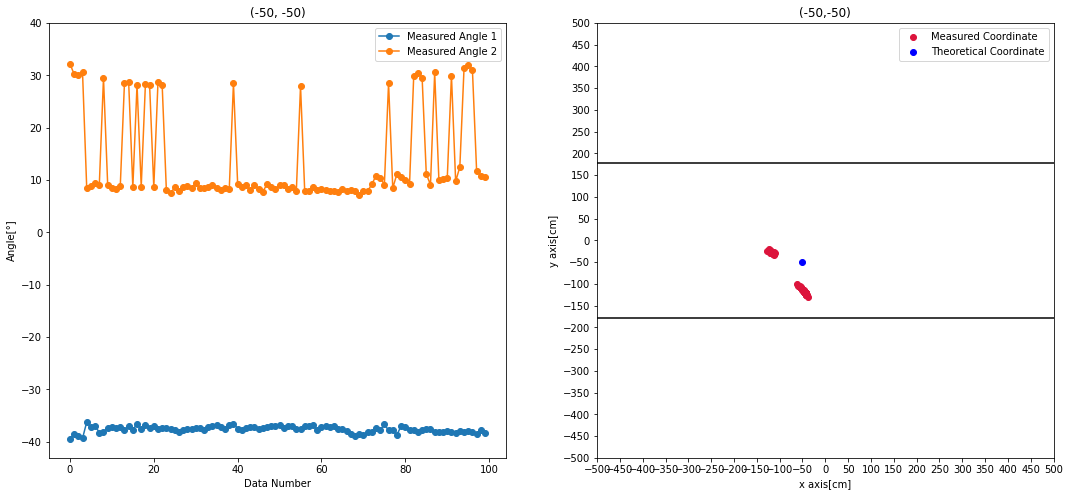

In [103]:
result = {}
triangulation = RfidDf(
    csv_file=DATA_FILE_PATH_LIST[1],
    antenna_pair_list=ANTENNA_PAIR_LIST,
    target_tag=TARGET_TAG,
)
result["angle_result1"]=triangulation.get_data_array("Pair1")["angle"]
result["angle_result2"]=triangulation.get_data_array("Pair2")["angle"]
result["coordinate"]=triangulation.get_coordinate()
rmse = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result1"]], marker='o', label="Measured Angle 1")
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result2"]], marker='o', label="Measured Angle 2")
ax1.set_ylabel("Angle[°]")
ax1.set_xlabel("Data Number")
ax1.set_yticks(range(-40, 45, 10))
ax1.set_title("(-50, -50)")
ax1.legend()
ax2.scatter(result["coordinate"]["X"], result["coordinate"]["Y"], label="Measured Coordinate", color="crimson")
ax2.scatter([-50], [-50], label="Theoretical Coordinate", color="blue")
ax2.plot(range(-500, 550, 50), [178 for i in range(-500, 550, 50)], color="black")
ax2.plot(range(-500, 550, 50), [-178 for i in range(-500, 550, 50)], color="black")
ax2.set_xlim(-500, 500)
ax2.set_ylim(-500, 500)
ax2.set_xticks(range(-500, 550, 50))
ax2.set_yticks(range(-500, 550, 50))
ax2.set_ylabel('y axis[cm]')
ax2.set_xlabel('x axis[cm]')
ax2.set_title("(-50,-50)")
rmse.append(cul_rmse(
    {
        "x":-50,
        "y":-50
    },
    {
        "x":result["coordinate"]["X"],
        "y":result["coordinate"]["Y"]
    }
))
ax2.legend()
print(rmse)

[181.09226658125715]


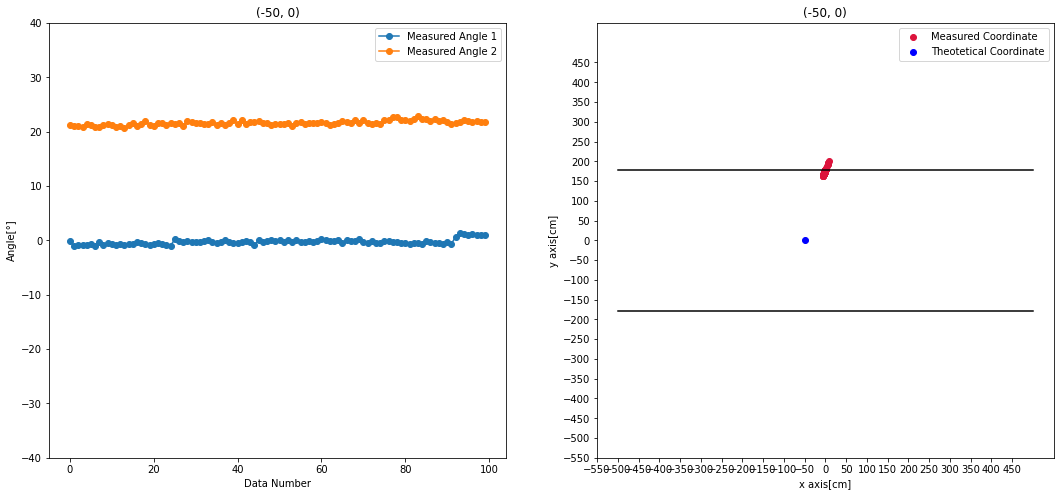

In [104]:
result = {}
triangulation = RfidDf(
    csv_file=DATA_FILE_PATH_LIST[2],
    antenna_pair_list=ANTENNA_PAIR_LIST,
    target_tag=TARGET_TAG,
)
result["angle_result1"]=triangulation.get_data_array("Pair1")["angle"]
result["angle_result2"]=triangulation.get_data_array("Pair2")["angle"]
result["coordinate"]=triangulation.get_coordinate()
rmse = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result1"]], marker='o', label="Measured Angle 1")
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result2"]], marker='o', label="Measured Angle 2")
ax1.set_ylabel("Angle[°]")
ax1.set_xlabel("Data Number")
ax1.set_yticks(range(-40, 45, 10))
ax1.set_title("(-50, 0)")
ax1.legend()
ax2.scatter(result["coordinate"]["X"], result["coordinate"]["Y"], label="Measured Coordinate", color="crimson")
ax2.scatter([-50], [0], label="Theotetical Coordinate", color="blue")
ax2.plot(range(-500, 550, 50), [178 for i in range(-500, 550, 50)], color="black")
ax2.plot(range(-500, 550, 50), [-178 for i in range(-500, 550, 50)], color="black")
ax2.set_xlim(-550, 550)
ax2.set_ylim(-550, 550)
ax2.set_xticks(range(-550, 500, 50))
ax2.set_yticks(range(-550, 500, 50))
ax2.set_ylabel('y axis[cm]')
ax2.set_xlabel('x axis[cm]')
ax2.set_title("(-50, 0)")
rmse.append(cul_rmse(
    {
        "x":-50,
        "y":0
    },
    {
        "x":result["coordinate"]["X"],
        "y":result["coordinate"]["Y"]
    }
))
ax2.legend()
print(rmse)

[408.21665667003765]


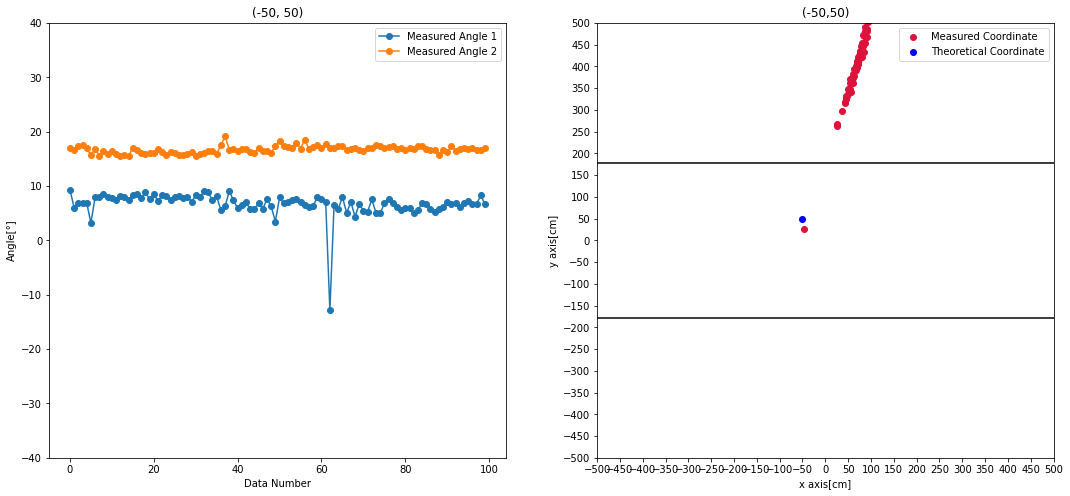

In [105]:
result = {}
triangulation = RfidDf(
    csv_file=DATA_FILE_PATH_LIST[3],
    antenna_pair_list=ANTENNA_PAIR_LIST,
    target_tag=TARGET_TAG,
)
result["angle_result1"]=triangulation.get_data_array("Pair1")["angle"]
result["angle_result2"]=triangulation.get_data_array("Pair2")["angle"]
result["coordinate"]=triangulation.get_coordinate()
rmse = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result1"]], marker='o', label="Measured Angle 1")
ax1.plot(range(0,100), [r * 180 / np.pi for r in result["angle_result2"]], marker='o', label="Measured Angle 2")
ax1.set_ylabel("Angle[°]")
ax1.set_xlabel("Data Number")
ax1.set_yticks(range(-40, 45, 10))
ax1.set_title("(-50, 50)")
ax1.legend()
ax2.scatter(result["coordinate"]["X"], result["coordinate"]["Y"],label="Measured Coordinate",  color="crimson")
ax2.scatter([-50], [50], label="Theoretical Coordinate",color="blue")
ax2.plot(range(-500, 550, 50), [178 for i in range(-500, 550, 50)], color="black")
ax2.plot(range(-500, 550, 50), [-178 for i in range(-500, 550, 50)], color="black")
ax2.set_xlim(-500, 500)
ax2.set_ylim(-500, 500)
ax2.set_xticks(range(-500, 550, 50))
ax2.set_yticks(range(-500, 550, 50))
ax2.set_ylabel('y axis[cm]')
ax2.set_xlabel('x axis[cm]')
ax2.set_title("(-50,50)")
rmse.append(cul_rmse(
    {
        "x":-50,
        "y":50
    },
    {
        "x":result["coordinate"]["X"],
        "y":result["coordinate"]["Y"]
    }
))
ax2.legend()
print(rmse)